In [2]:
#importing libraries, models and metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import spectral_clustering, KMeans, AgglomerativeClustering
import seaborn as sns
from itertools import compress

In [3]:
df = pd.read_csv("conversion_data.csv")

In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


There seem to be a few variables, cleanly formatted. Let us see how the values are distributed!

In [4]:
# Checking the various points in the percentile to see the nature of the data

df.describe(percentiles=[.25, .50, .75, 0.66, 0.33])

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
66%,34.000000,1.000000,6.000000,0.000000
33%,26.000000,1.000000,3.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


The Max age seems to be curiously high, let's see what the ages look like visually

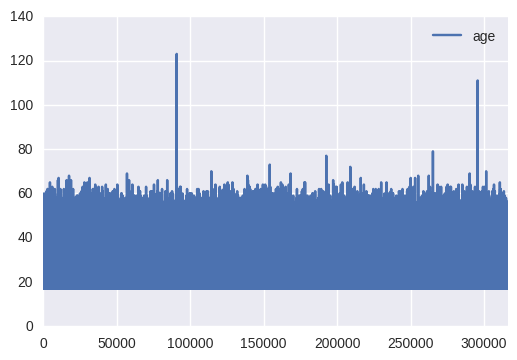

In [5]:
df.country.unique()
df[["age"]].plot()

#Looks like there are only two outliers.

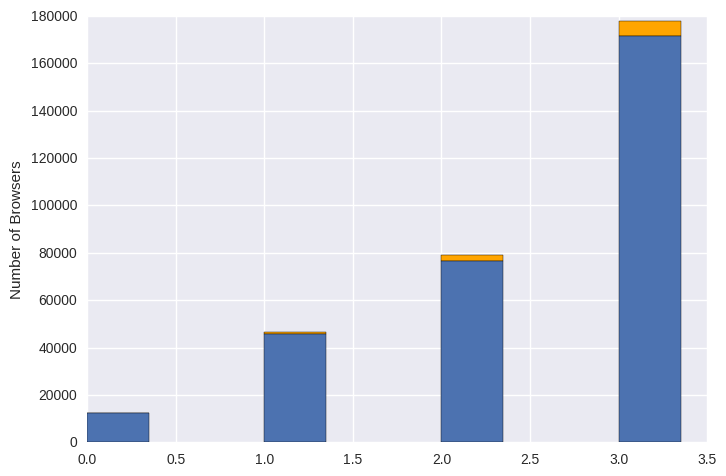

In [16]:
sns.set(style="darkgrid")
converts = df[df["converted"]==1].country.value_counts(ascending=True)
holdouts = df[df["converted"]==0].country.value_counts(ascending=True)
# sorted_category_counts.plot(kind='bar', figsize=(4,4), title="Column by Country");

ind = np.arange(4)
width = 0.35  

p1 = plt.bar(ind, converts, width, color='orange',
             bottom=holdouts)
p2 = plt.bar(ind, holdouts, width)

plt.ylabel('Number of Browsers')
# plt.title('Scores by group and gender')
# plt.legend((p1[0], p2[0]), ('Payers', 'Nonpayers'))

plt.show()

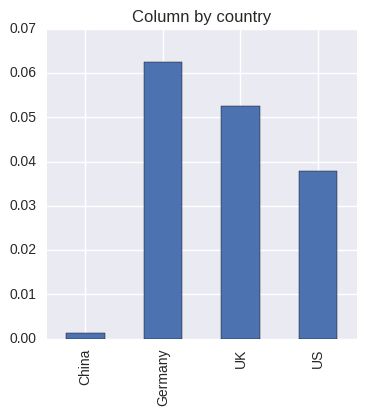

In [18]:
sorted_category_counts = df[df["converted"]==1].country.value_counts()/df.country.value_counts()
sorted_category_counts.plot(kind='bar', figsize=(4,4), title="Column by country", );

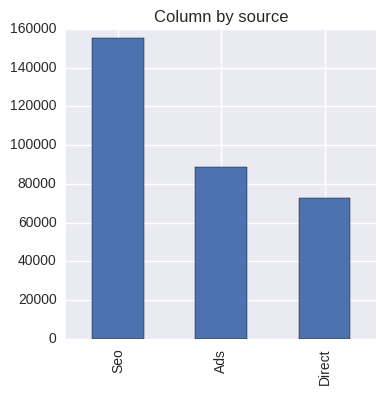

In [19]:

sorted_category_counts = df.source.value_counts()
sorted_category_counts.plot(kind='bar', figsize=(4,4), title="Column by source");

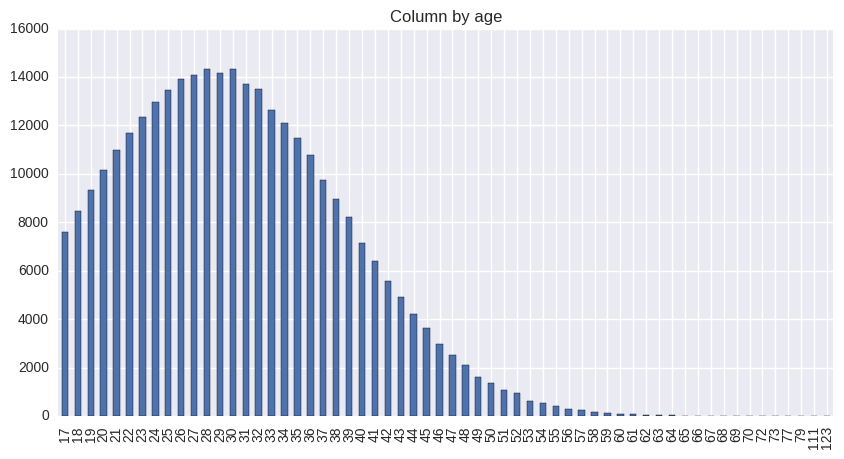

In [20]:
sorted_category_counts = df.age.value_counts().sort_index(ascending=True)
sorted_category_counts.plot(kind='bar', figsize=(10,5), title="Column by age");

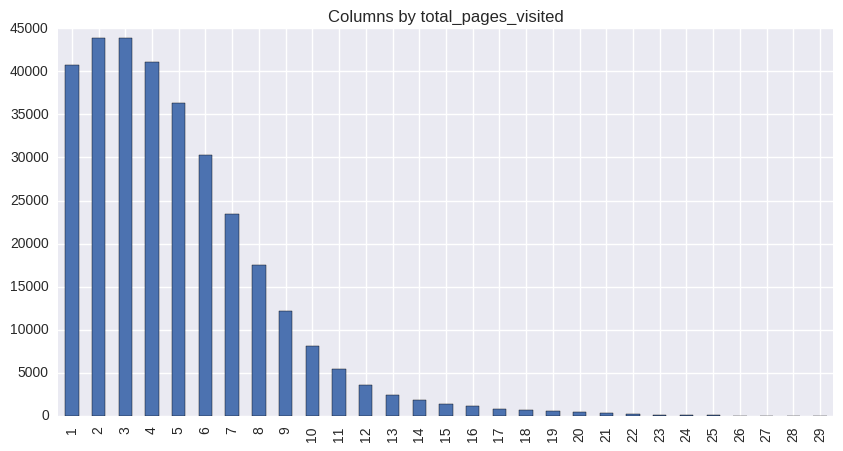

In [21]:
sorted_category_counts = df.total_pages_visited.value_counts().sort_index(ascending=True)
sorted_category_counts.plot(kind='bar', figsize=(10,5), title="Columns by total_pages_visited");

### Creating Bins for age group and engagement

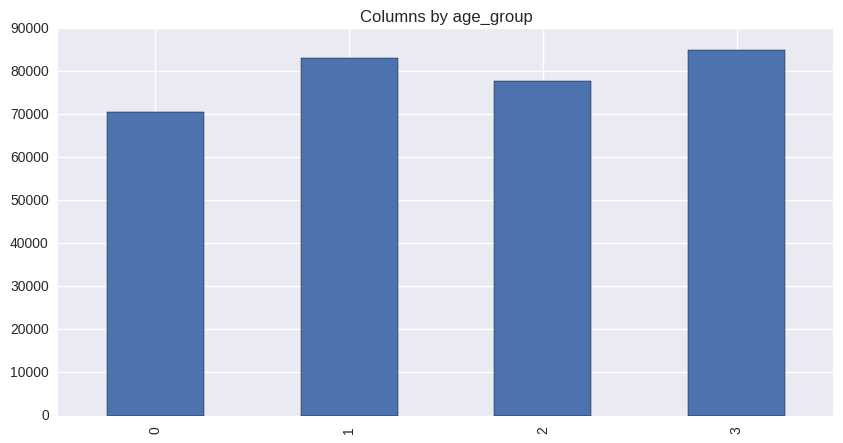

In [84]:
df["age_group"] = df.age.map(lambda x: 0 if x < 24 else 1 if x < 30 else 2 if x < 36 else 3)
sorted_category_counts = df.age_group.value_counts().sort_index(ascending=True)
sorted_category_counts.plot(kind='bar', figsize=(10,5), title="Columns by age_group");

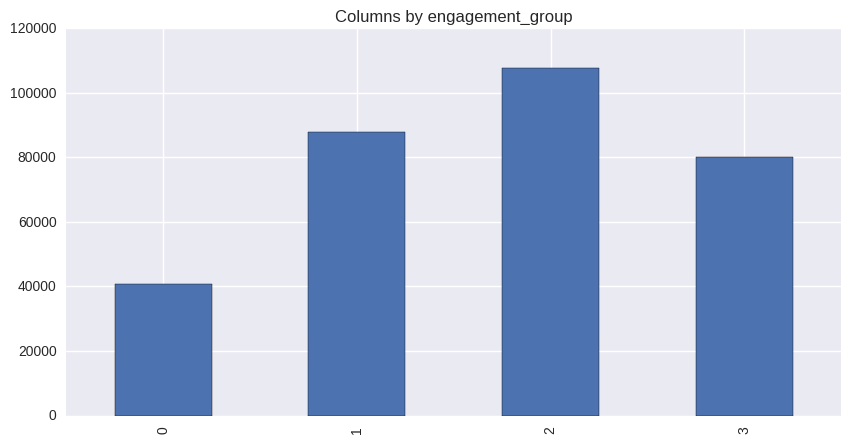

In [85]:
df["engagement_group"] = df.total_pages_visited.map(lambda x: 0 if x < 2 else 1 if x < 4 else 2 if x < 7 else 3)
sorted_category_counts = df.engagement_group.value_counts().sort_index(ascending=True)
sorted_category_counts.plot(kind='bar', figsize=(10,5), title="Columns by engagement_group");

In [7]:
pd.get_dummies(df.country).head()

,China,Germany,UK,US
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0


### Creating Dummy Variables

In [25]:
df["UK"] = pd.get_dummies(df.country)["UK"]
df["US"] = pd.get_dummies(df.country)["US"]
df["China"] = pd.get_dummies(df.country)["China"]
df["Germany"] = pd.get_dummies(df.country)["Germany"]

In [26]:
# pd.get_dummies(df.source)
df["Ads"] = pd.get_dummies(df.source)["Ads"]
df["Direct"] = pd.get_dummies(df.source)["Direct"]
df["Seo"] = pd.get_dummies(df.source)["Seo"]

In [31]:
df.head()

,country,age,new_user,source,total_pages_visited,converted,age_group,engagement_group,UK,US,China,Germany,Ads,Direct,Seo
0,UK,25,1,Ads,1,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,US,23,1,Seo,5,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,US,28,1,Seo,4,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,China,39,1,Seo,5,0,2,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,US,30,1,Seo,6,0,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [28]:
processed_df = df.copy()

In [29]:
del processed_df["country"]

In [30]:
del processed_df["source"]

In [32]:
processed_df.head()

,age,new_user,total_pages_visited,converted,age_group,engagement_group,UK,US,China,Germany,Ads,Direct,Seo
0,25,1,1,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,23,1,5,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,28,1,4,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,39,1,5,0,2,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,30,1,6,0,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Ready to build a classification model

### Use this code for cross validation, stratifiction and balancing weights!

In [97]:
## Look here for cross validation, stratified sampling.

df_X = processed_df
df_X = df_X.drop('converted', 1)
X_std = MinMaxScaler().fit_transform(df_X)
# X_std = MinMaxScaler().fit_transform(df_X)
# print(X_std)
X = X_std
df_y = processed_df.converted
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)



eval_size = 0.10
skf = StratifiedKFold(y_train, n_folds=round(1/eval_size))

selector = SelectKBest(chi2, k=8)
scaler = StandardScaler()
forest = RandomForestClassifier(class_weight=None) #Use auto, or a hand-coded dict to vary this.
training_classifier = Pipeline([('feature_selector',selector),
                                    ('classifier',forest)
                                   ])

for train_index, validate_index in skf:
#     print("TRAIN:", train_index, "TEST:", validate_index, len(validate_index), len(train_index))
    X_crosstrain, X_validate = X_train[train_index], X_train[validate_index]
    y_crosstrain, y_validate = y_train[train_index], y_train[validate_index]
    
    
    training_classifier = training_classifier.fit(X_crosstrain,y_crosstrain)
    
    trial_predictions = training_classifier.predict(X_validate)
    accuracy = accuracy_score(y_validate, trial_predictions)
    print("Accuracy: " + str(round(accuracy*100, 2)) + "%")
    print("AUC Score: " + str(round(roc_auc_score(y_validate, trial_predictions)*100, 2)) + "%")
    print()
    ## Printing Classification Report as accuracy is not a good measure when the classes are as imbalanced as this
    ## The focus should be on the scores for the 'Payer' category.
    print(classification_report(y_validate, trial_predictions, target_names=['Non Converted', 'Converted']))
    print()
    print()
    

Accuracy: 98.57%
AUC Score: 82.85%

               precision    recall  f1-score   support

Non Converted       0.99      1.00      0.99     24480
    Converted       0.86      0.66      0.75       816

  avg / total       0.98      0.99      0.98     25296



Accuracy: 98.46%
AUC Score: 83.57%

               precision    recall  f1-score   support

Non Converted       0.99      0.99      0.99     24480
    Converted       0.81      0.68      0.74       816

  avg / total       0.98      0.98      0.98     25296



Accuracy: 98.54%
AUC Score: 82.9%

               precision    recall  f1-score   support

Non Converted       0.99      1.00      0.99     24480
    Converted       0.85      0.66      0.74       816

  avg / total       0.98      0.99      0.98     25296



Accuracy: 98.55%
AUC Score: 83.02%

               precision    recall  f1-score   support

Non Converted       0.99      1.00      0.99     24480
    Converted       0.85      0.66      0.75       816

  avg / total  

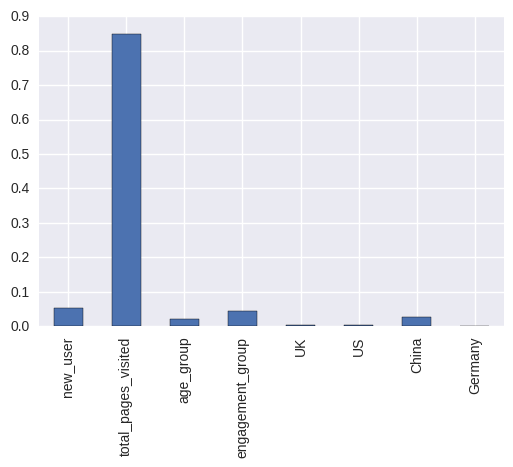

In [87]:
fil = selector.get_support()
col_list = list(df_X.columns.values)
relevant_features = list(compress(col_list, fil))
feature_importance = pd.Series(forest.feature_importances_, index = relevant_features)
feature_importance.plot.bar()

0.737310246679
               precision    recall  f1-score   support

Non Converted       0.99      0.74      0.84     24480
    Converted       0.08      0.71      0.15       816

  avg / total       0.96      0.74      0.82     25296


0.725332068311
               precision    recall  f1-score   support

Non Converted       0.99      0.72      0.84     24480
    Converted       0.08      0.75      0.15       816

  avg / total       0.96      0.73      0.81     25296


0.740512333966
               precision    recall  f1-score   support

Non Converted       0.99      0.74      0.85     24480
    Converted       0.09      0.72      0.15       816

  avg / total       0.96      0.74      0.82     25296


0.723869386464
               precision    recall  f1-score   support

Non Converted       0.99      0.72      0.84     24480
    Converted       0.08      0.76      0.15       816

  avg / total       0.96      0.72      0.81     25296


0.735412713472
               precision    r

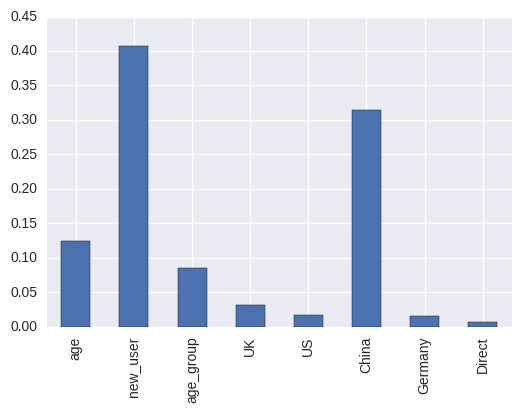

In [90]:
df_X = processed_df
df_X = df_X.drop('converted', 1)
df_X = df_X.drop('total_pages_visited', 1)
df_X = df_X.drop('engagement_group', 1)
X_std = MinMaxScaler().fit_transform(df_X)
# X_std = MinMaxScaler().fit_transform(df_X)
# print(X_std)
X = X_std
df_y = processed_df.converted
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)



eval_size = 0.10
skf = StratifiedKFold(y_train, n_folds=round(1/eval_size))

selector = SelectKBest(chi2, k=8)
scaler = StandardScaler()
forest = RandomForestClassifier(class_weight='auto')
training_classifier = Pipeline([('feature_selector',selector),
                                    ('classifier',forest)
                                   ])

for train_index, validate_index in skf:
#     print("TRAIN:", train_index, "TEST:", validate_index, len(validate_index), len(train_index))
    X_crosstrain, X_validate = X_train[train_index], X_train[validate_index]
    y_crosstrain, y_validate = y_train[train_index], y_train[validate_index]
    
    
    training_classifier = training_classifier.fit(X_crosstrain,y_crosstrain)
    
    trial_predictions = training_classifier.predict(X_validate)
    accuracy = accuracy_score(y_validate, trial_predictions)
    print(accuracy)
    ## Printing Classification Report as accuracy is not a good measure when the classes are as imbalanced as this
    ## The focus should be on the scores for the 'Payer' category.
    print(classification_report(y_validate, trial_predictions, target_names=['Non Converted', 'Converted']))
    print()
    
fil = selector.get_support()
col_list = list(df_X.columns.values)
relevant_features = list(compress(col_list, fil))
feature_importance = pd.Series(forest.feature_importances_, index = relevant_features)
feature_importance.plot.bar()
    